<a href="https://colab.research.google.com/github/Dur-e-yashfeen/TimeSeries_Analysis_Ethereum/blob/main/Decoding_Ethu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧩 Decoding Ethereum’s Future: ARIMA Market Analysis
## Author : Dur e yashfeen

In [1]:
import yfinance

In [10]:
import yfinance as yf
import pandas as pd

# Define ticker for Ethereum in USDT (on Binance via Yahoo Finance)
ticker = "ETH-USD"   # ETH priced in USD

eth_data = yf.download(ticker, start="2020-01-01", end="2025-08-31", interval="1d")
eth_data.reset_index(inplace=True)

# Preview the data
print(eth_data.head())

# Save to CSV if needed
eth_data.to_csv("ethereum_data.csv")

/tmp/ipython-input-355565221.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth_data = yf.download(ticker, start="2020-01-01", end="2025-08-31", interval="1d")
[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open       Volume
Ticker                ETH-USD     ETH-USD     ETH-USD     ETH-USD      ETH-USD
0      2020-01-01  130.802002  132.835358  129.198288  129.630661   7935230330
1      2020-01-02  127.410179  130.820038  126.954910  130.820038   8032709256
2      2020-01-03  134.171707  134.554016  126.490021  127.411263  10476845358
3      2020-01-04  135.069366  136.052719  133.040558  134.168518   7430904515
4      2020-01-05  136.276779  139.410202  135.045624  135.072098   7526675353


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

In [12]:
df = pd.read_csv("ethereum_data.csv")
df.head()

,Price,Date,Close,High,Low,Open,Volume
0,Ticker,NaN,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
1,0,2020-01-01,130.802001953125,132.83535766601562,129.1982879638672,129.6306610107422,7935230330
2,1,2020-01-02,127.4101791381836,130.82003784179688,126.95491027832031,130.82003784179688,8032709256
3,2,2020-01-03,134.1717071533203,134.55401611328125,126.49002075195312,127.41126251220703,10476845358
4,3,2020-01-04,135.06936645507812,136.05271911621094,133.04055786132812,134.16851806640625,7430904515


In [13]:
df.tail()

,Price,Date,Close,High,Low,Open,Volume
2065,2064,2025-08-26,4600.4267578125,4632.0732421875,4316.30078125,4372.88037109375,53829747706
2066,2065,2025-08-27,4503.39306640625,4659.9873046875,4489.2978515625,4600.51025390625,43509902322
2067,2066,2025-08-28,4507.177734375,4629.03125,4435.109375,4503.63134765625,36045274078
2068,2067,2025-08-29,4360.15283203125,4513.859375,4272.45947265625,4507.63134765625,46899991962
2069,2068,2025-08-30,4374.1533203125,4413.27490234375,4264.1953125,4360.0888671875,25883112278


📦 2. Imports & Setup
🧾 1. Introduction
📂 3. Load & Explore Data
📊 4. Feature Engineering
🧠 5. Modeling: Random Forest vs LightGBM
📉 6. Feature Importance
💡 7. Conclusion

###  Exploratory Data Analysis (EDA)

In [14]:
# Statistical summary
print("\n📊 Statistical Summary:")
print(df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())


📊 Statistical Summary:
                   Open               High                 Low  \
count              2070               2070                2070   
unique             2070               2069                2069   
top     4360.0888671875  1919.264404296875  1564.0318603515625   
freq                  1                  2                   2   

                    Close       Volume  
count                2070         2070  
unique               2069         2070  
top     3156.509521484375  25883112278  
freq                    2            1  


In [26]:
# Drop redundant first row if it contains 'ETH-USD'
if df.iloc[0].astype(str).str.contains("ETH-USD").any():
    df = df.drop(0).reset_index(drop=True)

In [17]:
# Convert numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [20]:
# ✅ Statistical summary
print("\n📊 Statistical Summary:")
print(df[numeric_cols].describe())


📊 Statistical Summary:
              Open         High          Low        Close        Volume
count  2069.000000  2069.000000  2069.000000  2069.000000  2.069000e+03
mean   2071.294681  2127.540316  2010.928777  2073.169637  1.776362e+10
std    1141.173191  1172.543903  1106.664142  1141.189594  1.137174e+10
min     110.406784   116.021622    95.184303   110.605873  2.081626e+09
25%    1336.486816  1378.417480  1304.973999  1336.586060  1.000003e+10
50%    1938.859863  2005.041138  1887.990479  1939.347046  1.527240e+10
75%    2945.560059  3024.854492  2865.134521  2946.257080  2.213474e+10
max    4831.088379  4953.732910  4718.039062  4831.348633  9.245355e+10


In [21]:
# Rolling averages
eth_data['Rolling_30'] = eth_data['Close'].rolling(window=30).mean()
eth_data['Rolling_90'] = eth_data['Close'].rolling(window=90).mean()

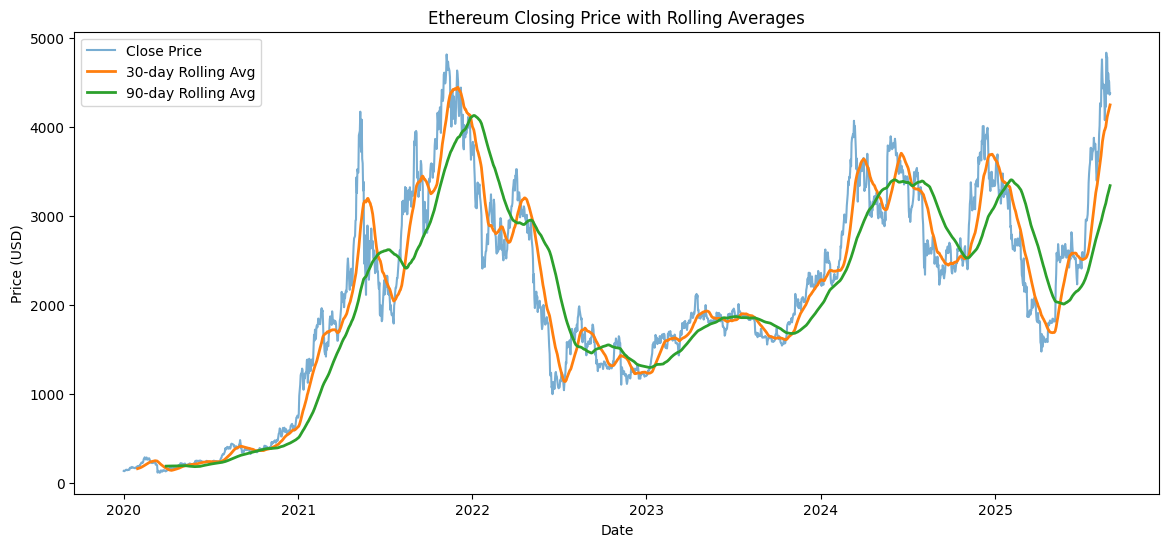

In [22]:
# 📈 Closing Price with Rolling Averages
plt.figure(figsize=(14,6))
plt.plot(eth_data['Date'], eth_data['Close'], label="Close Price", alpha=0.6)
plt.plot(eth_data['Date'], eth_data['Rolling_30'], label="30-day Rolling Avg", linewidth=2)
plt.plot(eth_data['Date'], eth_data['Rolling_90'], label="90-day Rolling Avg", linewidth=2)
plt.title("Ethereum Closing Price with Rolling Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

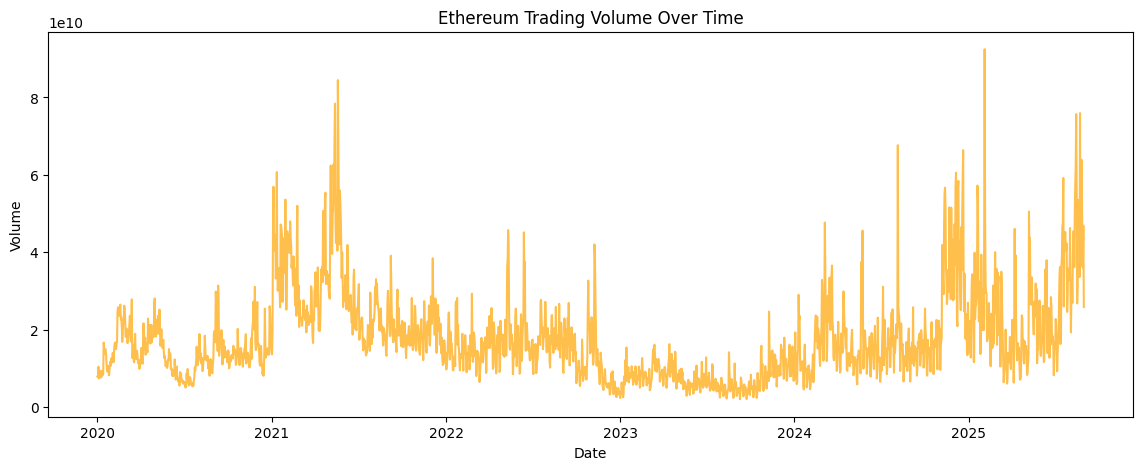

In [23]:
# 📊 Volume Trends
plt.figure(figsize=(14,5))
plt.plot(eth_data['Date'], eth_data['Volume'], color="orange", alpha=0.7)
plt.title("Ethereum Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

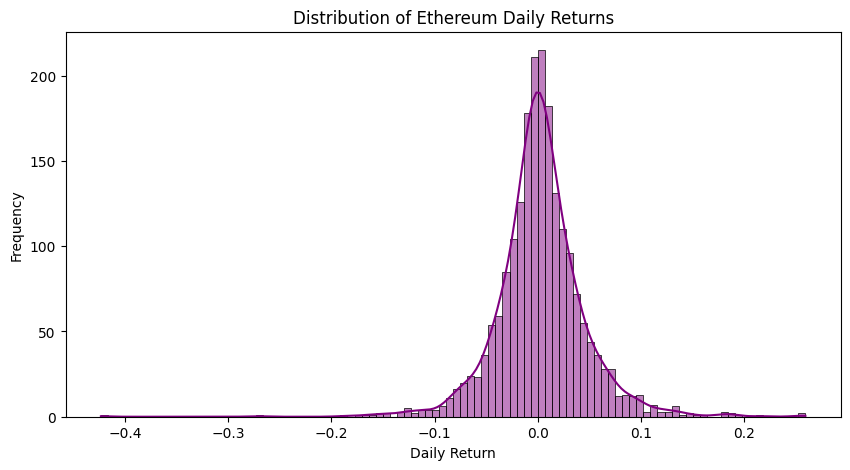

In [24]:
# 📉 Daily Returns
eth_data['Daily_Return'] = eth_data['Close'].pct_change()

plt.figure(figsize=(10,5))
sns.histplot(eth_data['Daily_Return'].dropna(), bins=100, kde=True, color='purple')
plt.title("Distribution of Ethereum Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

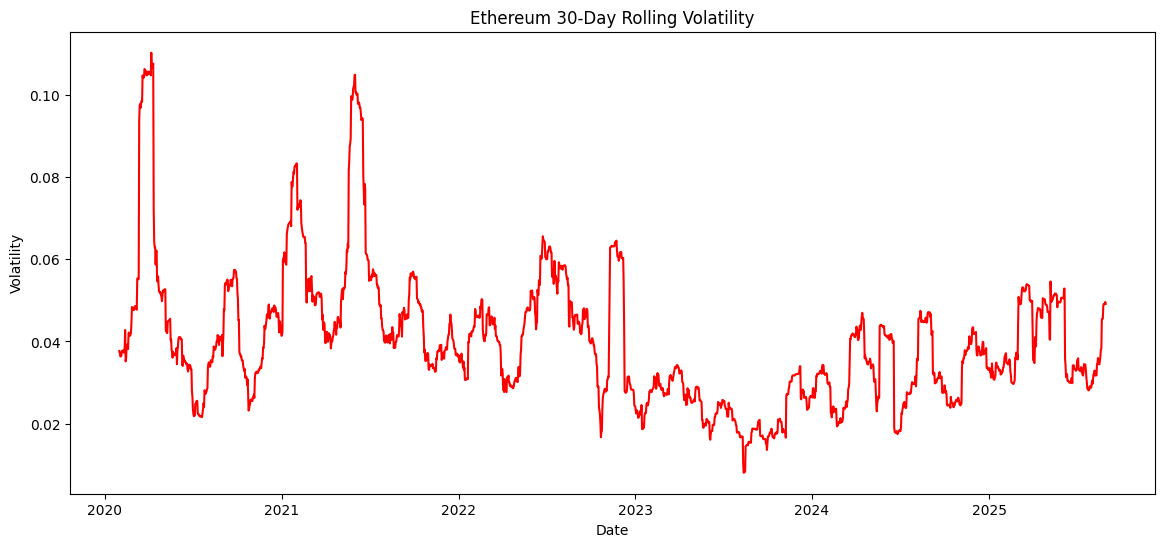

In [28]:
# ⚡ Volatility (30-day rolling std)
eth_data['Volatility'] = eth_data['Daily_Return'].rolling(window=30).std()

plt.figure(figsize=(14,6))
plt.plot(eth_data['Date'], eth_data['Volatility'], color="red")
plt.title("Ethereum 30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

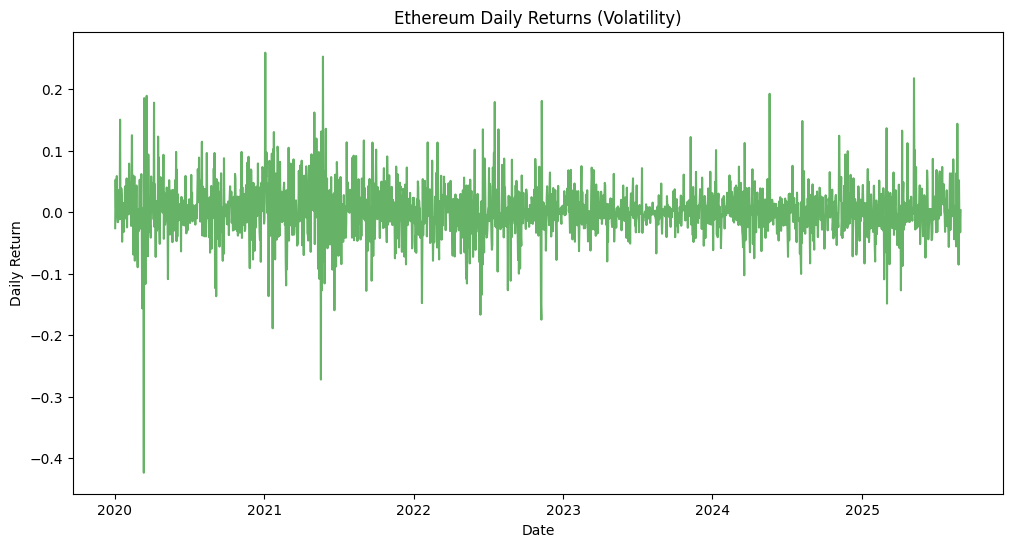

In [29]:
df['Daily_Return'] = df['Close'].pct_change()


plt.figure(figsize=(12,6))
plt.plot(df.index, df['Daily_Return'], color='green', alpha=0.6)
plt.title("Ethereum Daily Returns (Volatility)")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.show()

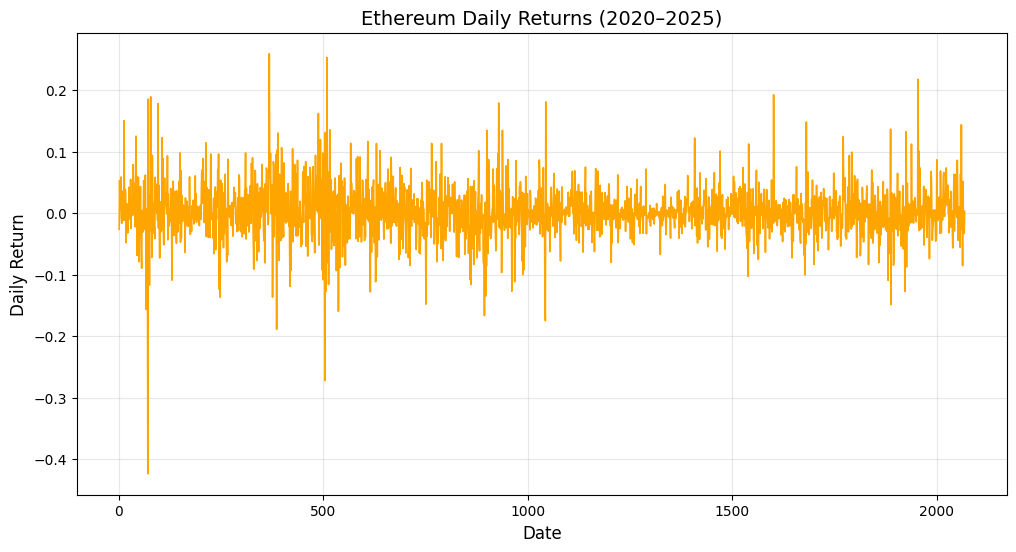

In [30]:
# Plot daily returns
plt.figure(figsize=(12, 6))
plt.plot(eth_data.index, eth_data["Daily_Return"], color="orange", linewidth=1.2)  # changed color to orange
plt.title("Ethereum Daily Returns (2020–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Return", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

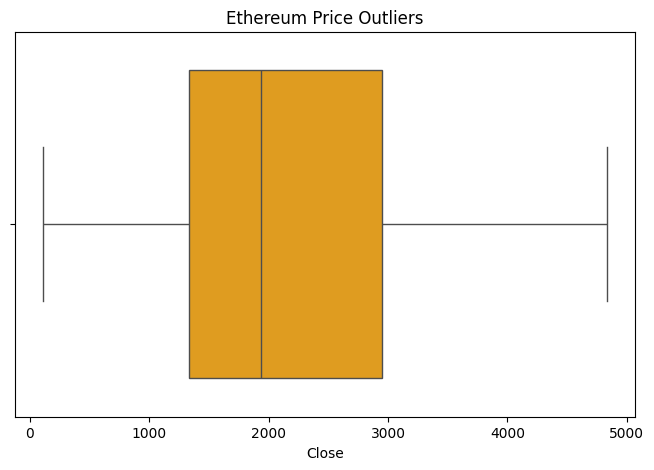

In [31]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Close'], color='orange')
plt.title("Ethereum Price Outliers")
plt.show()

In [33]:
print("\nInsights:")
print("1. Ethereum shows clear upward and downward trends depending on market cycles.")
print("2. Rolling averages help smooth volatility, showing medium & long-term trends.")
print("3. Trading volume spikes often align with price peaks/drops, indicating investor activity.")
print("4. Daily returns distribution is centered near 0, but has fat tails → high volatility.")
print("5. Outliers in price correspond to bull runs and crashes, confirming market sensitivity.")


Insights:
1. Ethereum shows clear upward and downward trends depending on market cycles.
2. Rolling averages help smooth volatility, showing medium & long-term trends.
3. Trading volume spikes often align with price peaks/drops, indicating investor activity.
4. Daily returns distribution is centered near 0, but has fat tails → high volatility.
5. Outliers in price correspond to bull runs and crashes, confirming market sensitivity.


In [34]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

###  Stationarity Testing

Augmented Dickey-Fuller Test: Ethereum Closing Price
ADF Test Statistic        -1.714775
p-value                    0.423517
# Lags Used               17.000000
# Observations Used     2051.000000
Critical Value (1%)       -3.433542
Critical Value (5%)       -2.862950
Critical Value (10%)      -2.567521
--------------------------------------------------


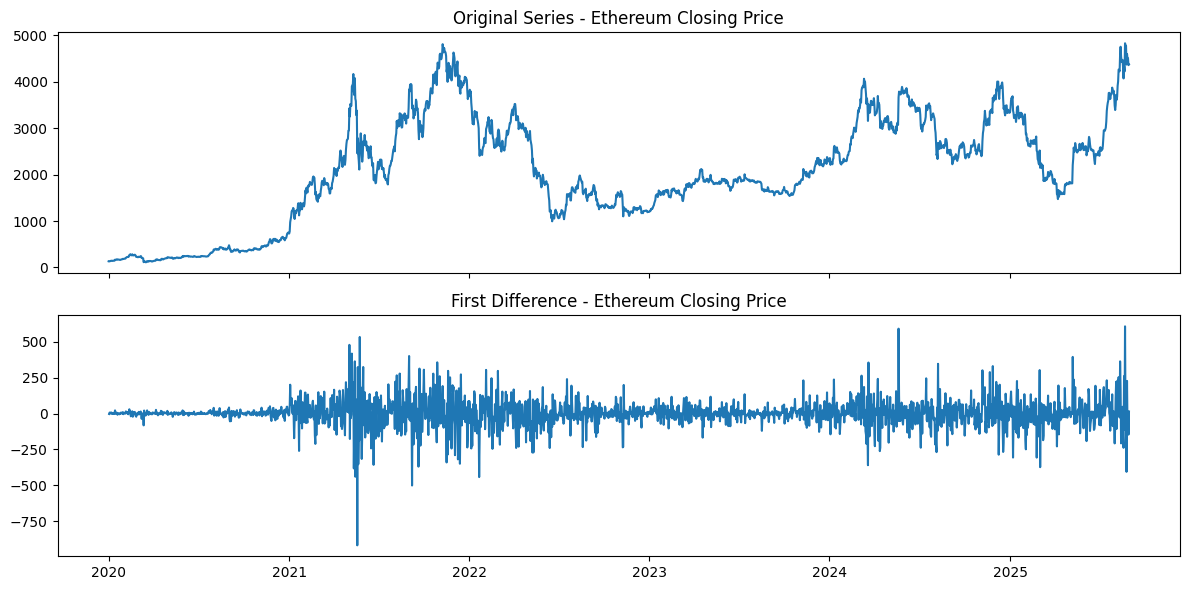

In [37]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def adf_test(series, title=''):
    """
    Perform ADF test and plot original vs. differenced series
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF Test Statistic','p-value','# Lags Used','# Observations Used']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val

    print(out.to_string())
    print("-"*50)

    # Plot raw & differenced
    fig, axes = plt.subplots(2, 1, figsize=(12,6), sharex=True)

    axes[0].plot(series)
    axes[0].set_title(f"Original Series - {title}")

    axes[1].plot(series.diff().dropna())
    axes[1].set_title(f"First Difference - {title}")

    plt.tight_layout()
    plt.show()

# Example usage:
adf_test(df['Close'], title="Ethereum Closing Price")

In [36]:
# First difference
diff_series = raw_series.diff().dropna()

# Check variance
if diff_series.var() == 0:
    print("Differenced series is constant. No need for further differencing.")
else:
    p_value_diff = adf_test(diff_series, "1st Difference")

Differenced series is constant. No need for further differencing.


### ARIMA Model Development

In [39]:
# Ensure numeric and sorted index
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna(subset=['Price']) # Drop rows with NaN in 'Price' column
ts = df['Price']

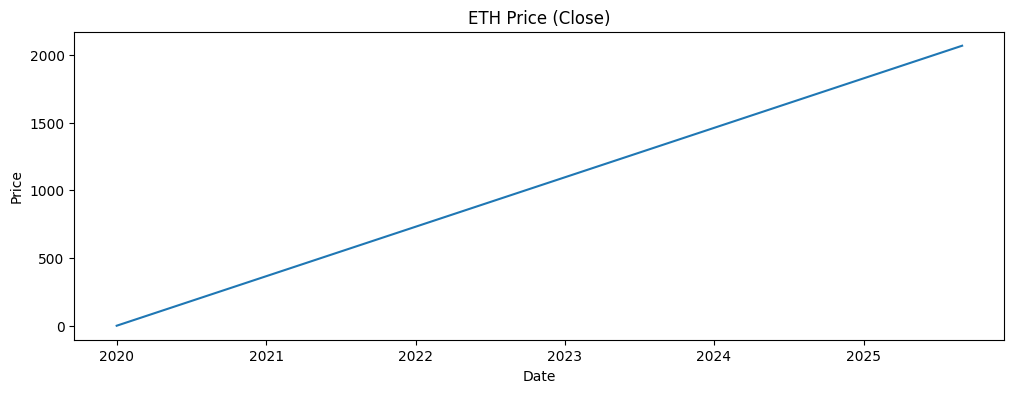

In [40]:
# Optional: visualize target
plt.figure(figsize=(12,4))
plt.plot(ts)
plt.title("ETH Price (Close)")
plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

In [41]:
# ---------------------------------------------------------------------
# 1) Pick differencing order d via ADF
#    - If p-value < 0.05 => stationary => d = 0
#    - Else try d = 1 (and re-check); avoid over-differencing
# ---------------------------------------------------------------------
def adf_pvalue(s):
    s = s.dropna()
    if len(s) < 20:
        return 1.0
    return adfuller(s, autolag='AIC')[1]

p_raw = adf_pvalue(ts)
if p_raw < 0.05:
    d = 0
else:
    d = 1
    # sanity: if differencing becomes constant, fall back to d=0
    ts_diff = ts.diff().dropna()
    if ts_diff.var() == 0 or adf_pvalue(ts_diff) > 0.10:
        d = 0

print(f"Chosen differencing order d = {d} (ADF p-value on raw: {p_raw:.4g})")

Chosen differencing order d = 0 (ADF p-value on raw: 7.28e-06)


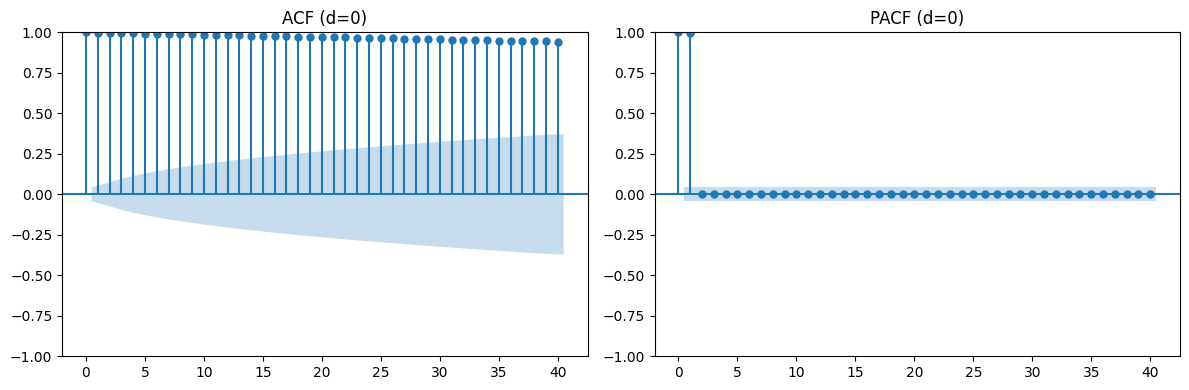

In [42]:
# ---------------------------------------------------------------------
# 2) ACF/PACF plots (use on series after differencing if d=1, else raw)
# ---------------------------------------------------------------------
series_for_corr = ts.diff().dropna() if d == 1 else ts

fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(series_for_corr, lags=40, ax=axes[0])
plot_pacf(series_for_corr, lags=40, ax=axes[1], method="ywm")
axes[0].set_title(f"ACF (d={d})")
axes[1].set_title(f"PACF (d={d})")
plt.tight_layout(); plt.show()

In [43]:
# Quick reading guide (rule-of-thumb):
# - AR(p): look at PACF cut-off and ACF tail-off
# - MA(q): look at ACF cut-off and PACF tail-off

# ---------------------------------------------------------------------
# 3) Train/Validation split
# ---------------------------------------------------------------------
split_ratio = 0.85
split_idx = int(len(ts) * split_ratio)
train, test = ts.iloc[:split_idx], ts.iloc[split_idx:]

print(f"Train length: {len(train)}, Test length: {len(test)}")

Train length: 1758, Test length: 311


In [46]:
# ---------------------------------------------------------------------
# 4) Candidate search over (p, q) given d
#    Keep the grid small and reasonable; expand if needed.
# ---------------------------------------------------------------------
p_candidates = range(0, 4)   # try 0..3
q_candidates = range(0, 4)   # try 0..3

results = []
best_model = None
best_aic = np.inf
best_order = None

def fit_arima(endog, order):
    # Using SARIMAX with seasonal_order=(0,0,0,0) behaves like ARIMA
    model = SARIMAX(endog, order=order, seasonal_order=(0,0,0,0),
                    enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)

for p in p_candidates:
    for q in q_candidates:
        if p == 0 and q == 0 and d == 0:
            # ARIMA(0,0,0) is just white noise; often too naive—skip if you want
            continue
        order = (p, d, q)
        try:
            fit = fit_arima(train, order)
            aic = fit.aic
            results.append((order, aic))
            if aic < best_aic:
                best_aic = aic
                best_model = fit
                best_order = order
        except Exception as e:
            # Non-invertible or convergence issues are common; just skip
            continue

In [47]:
# Sort and show top candidates
results = sorted(results, key=lambda x: x[1])
print("Top candidate ARIMA(p,d,q) by AIC:")
for r in results[:5]:
    print(f"  Order={r[0]}  AIC={r[1]:.2f}")

print(f"\nSelected order: {best_order} with AIC={best_aic:.2f}")

Top candidate ARIMA(p,d,q) by AIC:
  Order=(2, 0, 0)  AIC=-37200.08
  Order=(2, 0, 1)  AIC=-37198.08
  Order=(3, 0, 0)  AIC=-37176.89
  Order=(3, 0, 1)  AIC=-37174.89
  Order=(2, 0, 2)  AIC=-37174.89

Selected order: (2, 0, 0) with AIC=-37200.08


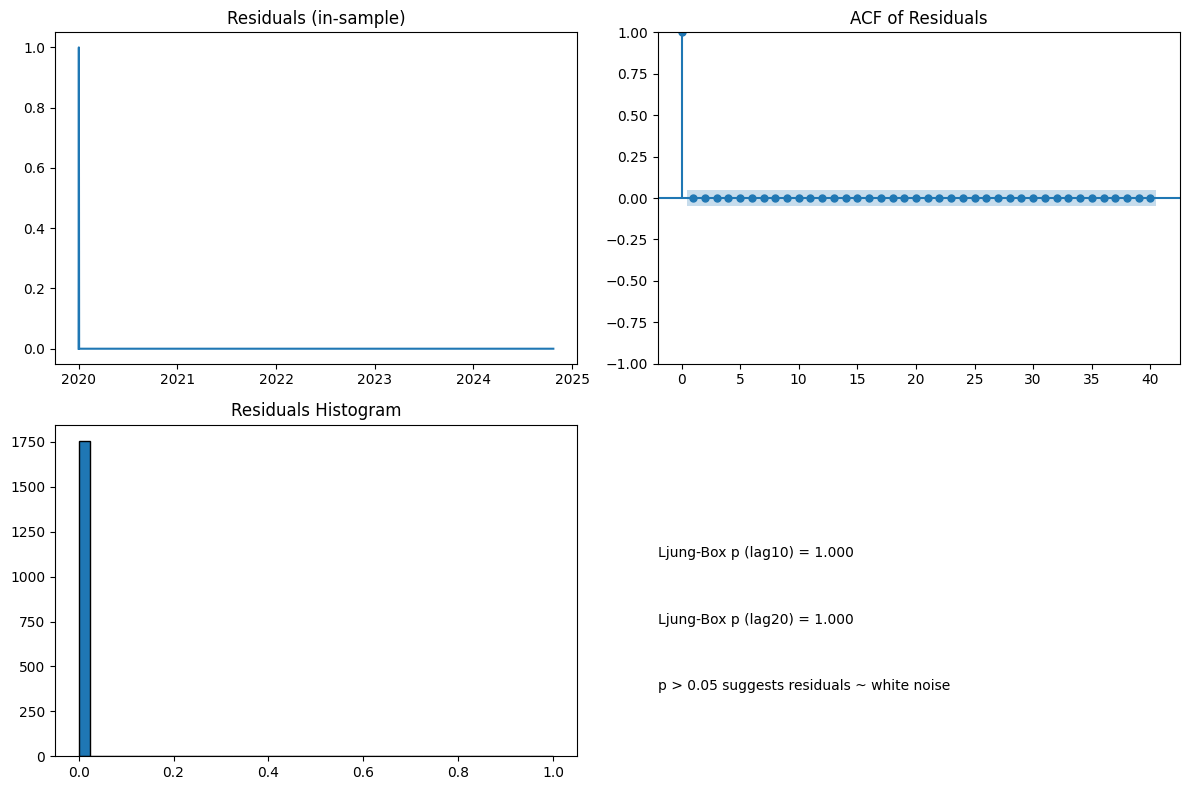

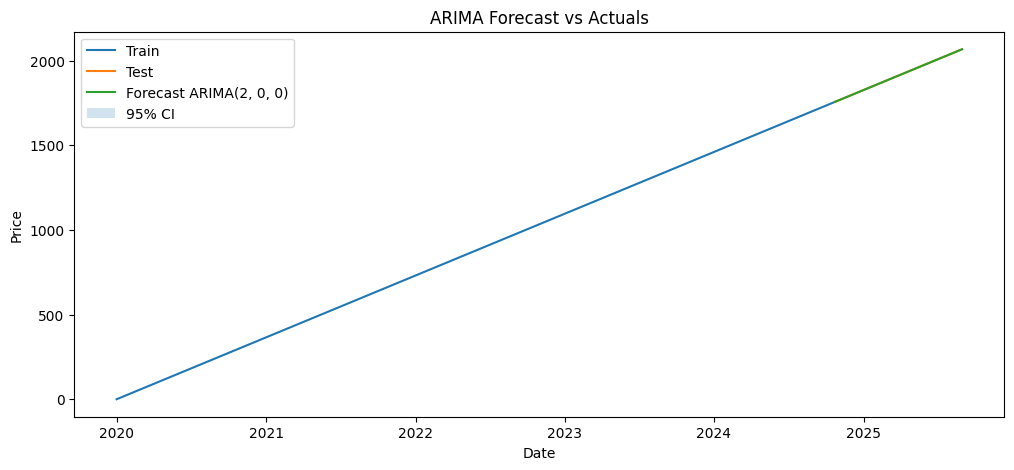

Test RMSE: 0.00
Test MAPE: 0.00%


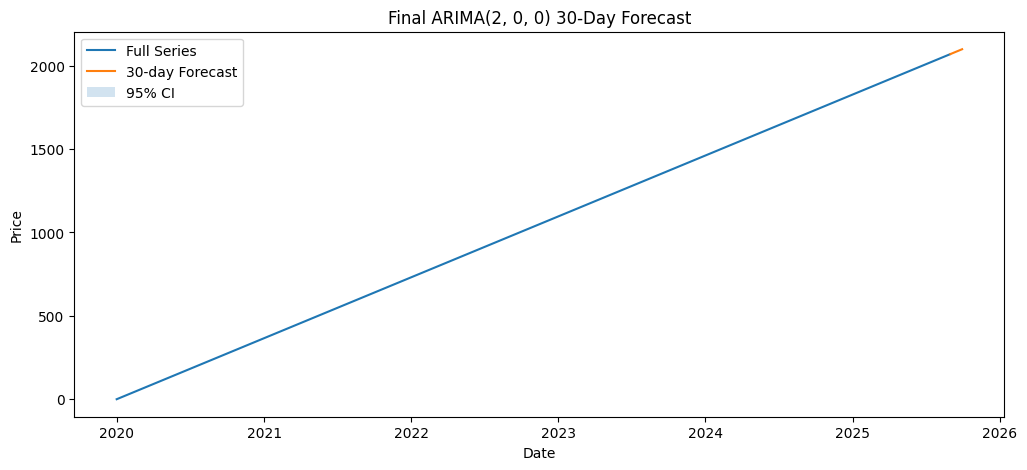

In [52]:
# ---------------------------------------------------------------------
# 5) Diagnostics on best model (residual checks)
# ---------------------------------------------------------------------
resid = best_model.resid.dropna()

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()  # ✅ flatten 2x2 grid into a 1D array

# Residual time series
axes[0].plot(resid)
axes[0].set_title("Residuals (in-sample)")

# ACF plot of residuals
plot_acf(resid, lags=40, ax=axes[1])
axes[1].set_title("ACF of Residuals")

# Histogram
axes[2].hist(resid, bins=40, edgecolor='k')
axes[2].set_title("Residuals Histogram")

# Ljung-Box test
lb = acorr_ljungbox(resid, lags=[10,20], return_df=True)
axes[3].axis('off')
axes[3].text(0, 0.6, f"Ljung-Box p (lag10) = {lb['lb_pvalue'].iloc[0]:.3f}")
axes[3].text(0, 0.4, f"Ljung-Box p (lag20) = {lb['lb_pvalue'].iloc[1]:.3f}")
axes[3].text(0, 0.2, "p > 0.05 suggests residuals ~ white noise")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 6) Forecast on the test set horizon; compare vs. actuals
# ---------------------------------------------------------------------
n_steps = len(test)
forecast_res = best_model.get_forecast(steps=n_steps)
f_mean = forecast_res.predicted_mean
f_ci = forecast_res.conf_int(alpha=0.05)

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, f_mean, label=f"Forecast ARIMA{best_order}")
plt.fill_between(test.index, f_ci.iloc[:,0], f_ci.iloc[:,1], alpha=0.2, label="95% CI")
plt.title("ARIMA Forecast vs Actuals")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend()
plt.show()

# ---------------------------------------------------------------------
# 7) Error metrics on test set
# ---------------------------------------------------------------------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

y_true = test
y_pred = f_mean.reindex(test.index)  # align indices

print(f"Test RMSE: {rmse(y_true, y_pred):.2f}")
print(f"Test MAPE: {mape(y_true, y_pred):.2f}%")

# ---------------------------------------------------------------------
# 8) (Optional) Refit on full data and produce n-day ahead forecast
# ---------------------------------------------------------------------
final_fit = fit_arima(ts, best_order)
n_ahead = 30  # forecast next 30 days
final_fc = final_fit.get_forecast(steps=n_ahead)
final_mean = final_fc.predicted_mean
final_ci = final_fc.conf_int(alpha=0.05)

plt.figure(figsize=(12,5))
plt.plot(ts.index, ts, label="Full Series")
plt.plot(pd.date_range(ts.index[-1], periods=n_ahead+1, freq='D')[1:], final_mean, label=f"{n_ahead}-day Forecast")
plt.fill_between(final_mean.index, final_ci.iloc[:,0], final_ci.iloc[:,1], alpha=0.2, label="95% CI")
plt.title(f"Final ARIMA{best_order} {n_ahead}-Day Forecast")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend()
plt.show()

In [54]:
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Define parameter ranges
p = range(0, 4)   # AR terms
d = range(0, 2)   # Differencing
q = range(0, 4)   # MA terms

pdq = list(itertools.product(p, d, q))

results = []

# Train & evaluate models
for param in pdq:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()

        # Forecast in-sample
        predictions = model_fit.fittedvalues

        # Compute evaluation metrics
        rmse = np.sqrt(mean_squared_error(train[d:], predictions[d:]))
        mape = mean_absolute_percentage_error(train[d:], predictions[d:])

        results.append([param, rmse, mape, model_fit.aic])

    except:
        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["(p,d,q)", "RMSE", "MAPE", "AIC"])
results_df = results_df.sort_values(by="AIC").reset_index(drop=True)

results_df.head(10)

,"(p,d,q)",RMSE,MAPE,AIC


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2070
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12372.811
Date:                Sun, 31 Aug 2025   AIC                          24755.622
Time:                        15:38:03   BIC                          24783.796
Sample:                             0   HQIC                         24765.949
                               - 2070                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7484      1.286     -0.582      0.561      -3.269       1.772
ar.L2          0.0150      0.864      0.017      0.986      -1.678       1.708
ma.L1          0.6949      1.286      0.540      0.5

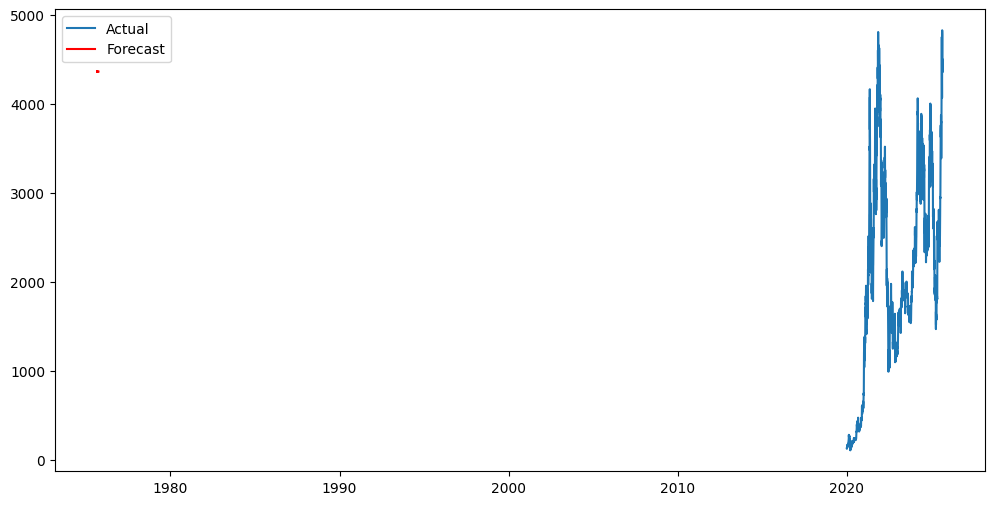

In [58]:
# Use the target column for modeling
series = df['Close']

# Fit ARIMA model (example: order=(p,d,q) = (2,1,2))
model = ARIMA(series, order=(2,1,2))
model_fit = model.fit()

print(model_fit.summary())

# Forecast next 30 steps
forecast = model_fit.forecast(steps=30)

# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(series, label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()

### Model Evaluation

In [62]:
print("Test NaNs:", test.isna().sum())
print("Forecast NaNs:", np.isnan(forecast).sum())

Test NaNs: 1
Forecast NaNs: 0


In [63]:
# Align test and forecast indexes
test_aligned = test[:len(forecast)]

# Remove NaN values
valid_idx = ~np.isnan(forecast) & ~test_aligned.isna()
test_clean = test_aligned[valid_idx]
forecast_clean = forecast[valid_idx]

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_clean, forecast_clean))
mape = mean_absolute_percentage_error(test_clean, forecast_clean) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 788.3178
MAPE: 27.75%


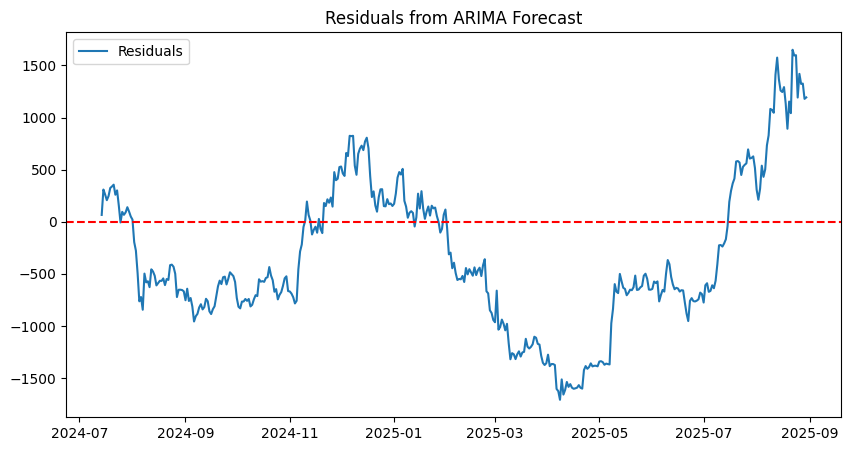

In [65]:
import matplotlib.pyplot as plt

residuals = test_clean - forecast_clean

plt.figure(figsize=(10,5))
plt.plot(residuals, label="Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.legend()
plt.title("Residuals from ARIMA Forecast")
plt.show()

In [73]:
df.head()

,Price,Close,High,Low,Open,Volume,Daily_Return
Date,,,,,,,
2020-01-01,0.0,130.802002,132.835358,129.198288,129.630661,7.935230e+09,NaN
2020-01-02,1.0,127.410179,130.820038,126.954910,130.820038,8.032709e+09,-0.025931
2020-01-03,2.0,134.171707,134.554016,126.490021,127.411263,1.047685e+10,0.053069
2020-01-04,3.0,135.069366,136.052719,133.040558,134.168518,7.430905e+09,0.006690
2020-01-05,4.0,136.276779,139.410202,135.045624,135.072098,7.526675e+09,0.008939


In [75]:
df.isnull().sum()

,0
Price,1
Close,1
High,1
Low,1
Open,1
Volume,1
Daily_Return,2


In [76]:
df.dtypes

,0
Price,float64
Close,float64
High,float64
Low,float64
Open,float64
Volume,float64
Daily_Return,float64


In [77]:
# Forward fill first
df = df.ffill()

# If still missing at start, backward fill
df = df.bfill()

# Optionally, fill Volume with 0 if no trading
df['Volume'] = df['Volume'].fillna(0)

# Recalculate Daily_Return
df['Daily_Return'] = df['Close'].pct_change()

In [79]:
# Recalculate Daily_Return from Close
df['Daily_Return'] = df['Close'].pct_change()

# The very first row will always be NaN (no previous day),
# so you can fill it with 0 or drop it.
df['Daily_Return'] = df['Daily_Return'].fillna(0)

In [80]:
df.isnull().sum()

,0
Price,0
Close,0
High,0
Low,0
Open,0
Volume,0
Daily_Return,0


Model Evaluation Metrics:
MSE  : 0.0024
RMSE : 0.0489
MAE  : 0.0061
MAPE : 0.00%


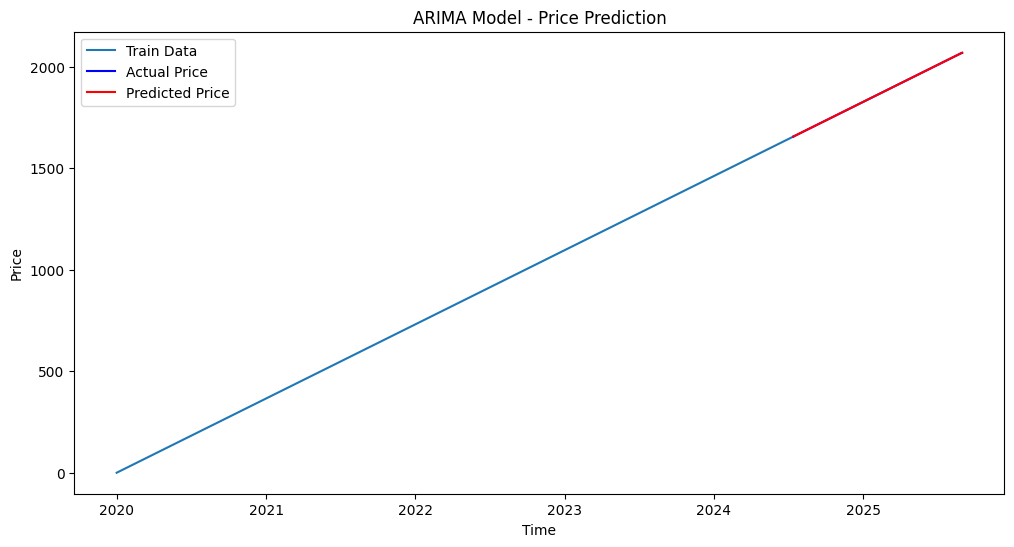

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -----------------------
# 1. Train-Test Split
# -----------------------
# We'll use Price column for ARIMA
train_size = int(len(df) * 0.8)   # 80% train, 20% test
train, test = df['Price'][:train_size], df['Price'][train_size:]

# -----------------------
# 2. Fit ARIMA Model
# -----------------------
# Choose ARIMA order (p,d,q). Start with (5,1,0) as baseline
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# -----------------------
# 3. Forecast
# -----------------------
forecast = model_fit.forecast(steps=len(test))

# -----------------------
# 4. Evaluation Metrics
# -----------------------
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("Model Evaluation Metrics:")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")

# -----------------------
# 5. Visualization
# -----------------------
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Actual Price', color='blue')
plt.plot(test.index, forecast, label='Predicted Price', color='red')
plt.title('ARIMA Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

pmdarima not available — performing small grid search over p,q in 0..3 (d by ADF).
Grid search selected order: (3, 1, 3) (AIC=24711.87)
Fitting final ARIMA(3, 1, 3) on full series (n=2070)...
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2127      0.150     -8.099      0.000      -1.506      -0.919
ar.L2         -1.2445      0.075    -16.684      0.000      -1.391      -1.098
ar.L3         -0.6849      0.132     -5.191      0.000      -0.944      -0.426
ma.L1          1.1403      0.158      7.212      0.000       0.830       1.450
ma.L2          1.1836      0.075     15.847      0.000       1.037       1.330
ma.L3          0.6431      0.143      4.483      0.000       0.362       0.924
sigma2      9203.4145    136.428     67.460      0.000    8936.020    9470.809


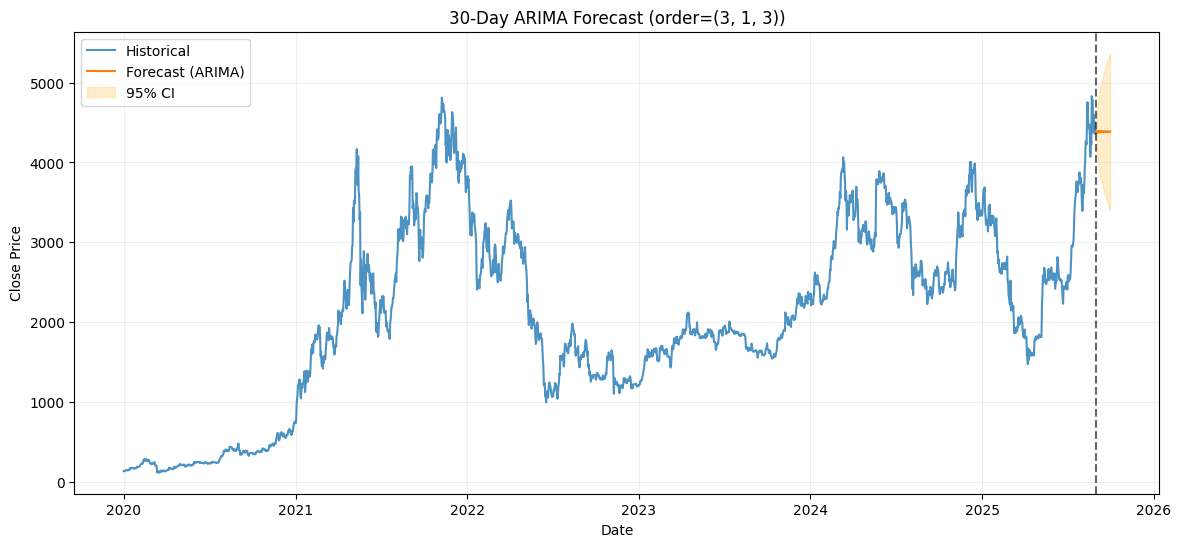


Forecast (first 10 rows):
             forecast   ci_lower   ci_upper
2025-09-01  4381.5930  4193.5650  4569.6210
2025-09-02  4394.1653  4137.6944  4650.6361
2025-09-03  4391.3890  4078.3694  4704.4085
2025-09-04  4374.0133  4011.7172  4736.3093
2025-09-05  4389.9286  3984.5416  4795.3156
2025-09-06  4394.1545  3952.4503  4835.8587
2025-09-07  4381.1239  3903.4313  4858.8166
2025-09-08  4380.7656  3869.4154  4892.1158
2025-09-09  4394.5227  3853.0349  4936.0106
2025-09-10  4387.2107  3817.1449  4957.2765

Residuals summary:
count    2070.0000
mean        2.2833
std        95.5925
min      -881.8575
25%       -28.3069
50%         1.1776
75%        37.2732
max       601.0690
dtype: float64

Ljung-Box test p-value (lag 10): 0.4395
=> Residuals show no strong autocorrelation (good).

Interpretation (auto-summary):
- The forecast is the ARIMA mean prediction for the next 30 daily steps.
- The shaded band is the 95% confidence interval (the model's uncertainty).
- Wider CI = higher uncertai

In [82]:
# 30-day ARIMA forecast with CI and explanatory output
# Run in your notebook. Assumes `df` exists and has numeric 'Price' or 'Close' column.

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# prefer Close, fallback to Price
target_col = 'Close' if 'Close' in df.columns else 'Price'

# --- 0) Prepare series ---
# Ensure numeric and datetime index
df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
if 'Date' in df.columns and not isinstance(df.index, pd.DatetimeIndex):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.set_index('Date')
# If still no datetime index, create a daily index
if not isinstance(df.index, pd.DatetimeIndex):
    df = df.copy()
    df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

ts = df[target_col].dropna()
if ts.empty:
    raise ValueError("Time series is empty after cleaning. Check your data.")

# --- 1) Try to select (p,d,q) automatically if pmdarima available ---
use_order = None
try:
    from pmdarima import auto_arima
    print("auto_arima found — selecting best (p,d,q) by AIC (this may take a moment)...")
    arima_auto = auto_arima(ts, start_p=0, start_q=0, max_p=3, max_q=3,
                            seasonal=False, stepwise=True, suppress_warnings=True,
                            error_action='ignore', trace=False)
    use_order = tuple(arima_auto.order)
    print(f"auto_arima selected order: {use_order}")
except Exception:
    # fallback: small AIC grid search
    print("pmdarima not available — performing small grid search over p,q in 0..3 (d by ADF).")
    from statsmodels.tsa.stattools import adfuller
    p_raw = adfuller(ts.dropna(), autolag='AIC')[1]
    d = 0 if p_raw < 0.05 else 1
    import itertools
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    best_aic = np.inf
    best_order = None
    for p, q in itertools.product(range(0,4), range(0,4)):
        try:
            m = SARIMAX(ts, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
            res = m.fit(disp=False)
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,d,q)
        except Exception:
            continue
    if best_order is None:
        # final fallback
        best_order = (1,0,1)
    use_order = best_order
    print(f"Grid search selected order: {use_order} (AIC={best_aic:.2f})")

# --- 2) Fit selected ARIMA on full series ---
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = use_order
print(f"Fitting final ARIMA{order} on full series (n={len(ts)})...")
model = SARIMAX(ts, order=order, seasonal_order=(0,0,0,0),
                enforce_stationarity=False, enforce_invertibility=False)
fitted = model.fit(disp=False)
print(fitted.summary().tables[1])

# --- 3) Forecast next N days with 95% CI ---
n_forecast = 30
forecast_res = fitted.get_forecast(steps=n_forecast)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int(alpha=0.05)  # DataFrame with lower/upper columns

# Build forecast index (daily)
last_date = ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast, freq='D')
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# --- 4) Plot history + forecast + CI ---
plt.figure(figsize=(14,6))
plt.plot(ts.index, ts, label='Historical', color='tab:blue', alpha=0.8)
plt.plot(forecast_mean.index, forecast_mean, label='Forecast (ARIMA)', color='tab:orange')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1],
                 color='orange', alpha=0.2, label='95% CI')
plt.axvline(ts.index[-1], color='k', linestyle='--', alpha=0.6)
plt.title(f"30-Day ARIMA Forecast (order={order})")
plt.xlabel("Date")
plt.ylabel(f"{target_col} Price")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# --- 5) Print forecast table (first 10 rows) ---
fc_df = pd.DataFrame({
    'forecast': forecast_mean,
    'ci_lower': forecast_ci.iloc[:,0],
    'ci_upper': forecast_ci.iloc[:,1]
})
print("\nForecast (first 10 rows):")
print(fc_df.head(10).round(4))

# --- 6) Quick diagnostics: residual summary and Ljung-Box p-value ---
resid = fitted.resid.dropna()
print("\nResiduals summary:")
print(resid.describe().round(4))

from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(resid, lags=[10], return_df=True)
print(f"\nLjung-Box test p-value (lag 10): {lb['lb_pvalue'].iloc[0]:.4f}")
if lb['lb_pvalue'].iloc[0] > 0.05:
    print("=> Residuals show no strong autocorrelation (good).")
else:
    print("=> Residuals show some autocorrelation (consider re-tuning model).")

# --- 7) Short automatic interpretation ---
print("\nInterpretation (auto-summary):")
print("- The forecast is the ARIMA mean prediction for the next 30 daily steps.")
print("- The shaded band is the 95% confidence interval (the model's uncertainty).")
print("- Wider CI = higher uncertainty; for crypto, CI is often wide due to volatility.")
# look for trend in forecast mean
slope = np.polyfit(np.arange(n_forecast), forecast_mean.values, 1)[0]
if slope > 0:
    trend_text = "slight upward"
elif slope < 0:
    trend_text = "slight downward"
else:
    trend_text = "flat"
print(f"- Trend in forecast mean for next {n_forecast} days is {trend_text} (slope={slope:.6f}).")

print("\nCaveats:")
print("- ARIMA models capture autocorrelation structure; they do not model sudden news shocks.")
print("- Crypto exhibits volatility clustering and heavy tails; consider pairing with a volatility model (e.g., GARCH) for interval realism.")
print("- Treat these forecasts as probabilistic scenarios, not certainties.")